In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import zipfile,os,random,shutil
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download grassknoted/asl-alphabet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 1.03G/1.03G [00:46<00:00, 25.4MB/s]
100% 1.03G/1.03G [00:46<00:00, 23.4MB/s]


In [30]:
! unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [31]:
img_data_gen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=10,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

In [ ]:
dirs = "EFGHIJKLMNOPQRSTUVWXYZ"
for dir in dirs: 
  img_label = "/content/asl_alphabet_train/asl_alphabet_train/" + dir
  !rm -r $img_label
dirs = ["del","nothing","space"]
for dir in dirs: 
  img_label = "/content/asl_alphabet_train/asl_alphabet_train/" + dir
  !rm -r $img_label

In [39]:
train_generator = img_data_gen.flow_from_directory(
        "/content/asl_alphabet_train/asl_alphabet_train",  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
        class_mode='categorical',
        subset='training')
 
validation_generator = img_data_gen.flow_from_directory(
        "/content/asl_alphabet_train/asl_alphabet_train", # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        class_mode='categorical',
        subset='validation')

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi model untuk data latih dan validasi sudah >85% !!")
      self.model.stop_training = True
callbacks = myCallback()

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adamax(),
              metrics=['accuracy'])

In [54]:
result = model.fit(
      train_generator,
      steps_per_epoch=50,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=50, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks])

Epoch 1/50
50/50 - 38s - loss: 1.4217 - accuracy: 0.2800 - val_loss: 1.3910 - val_accuracy: 0.3100 - 38s/epoch - 766ms/step
Epoch 2/50
50/50 - 2s - loss: 1.3716 - accuracy: 0.3150 - val_loss: 1.3904 - val_accuracy: 0.3500 - 2s/epoch - 37ms/step
Epoch 3/50
50/50 - 2s - loss: 1.2888 - accuracy: 0.4150 - val_loss: 1.3057 - val_accuracy: 0.4900 - 2s/epoch - 37ms/step
Epoch 4/50
50/50 - 2s - loss: 1.1064 - accuracy: 0.5100 - val_loss: 1.2312 - val_accuracy: 0.4400 - 2s/epoch - 36ms/step
Epoch 5/50
50/50 - 2s - loss: 0.9196 - accuracy: 0.5950 - val_loss: 1.1209 - val_accuracy: 0.5200 - 2s/epoch - 36ms/step
Epoch 6/50
50/50 - 3s - loss: 0.7283 - accuracy: 0.7200 - val_loss: 1.1443 - val_accuracy: 0.4400 - 3s/epoch - 53ms/step
Epoch 7/50
50/50 - 2s - loss: 0.6503 - accuracy: 0.7200 - val_loss: 0.8056 - val_accuracy: 0.6200 - 2s/epoch - 37ms/step
Epoch 8/50
50/50 - 2s - loss: 0.4538 - accuracy: 0.8350 - val_loss: 0.9668 - val_accuracy: 0.5600 - 2s/epoch - 37ms/step
Epoch 9/50
50/50 - 2s - loss:

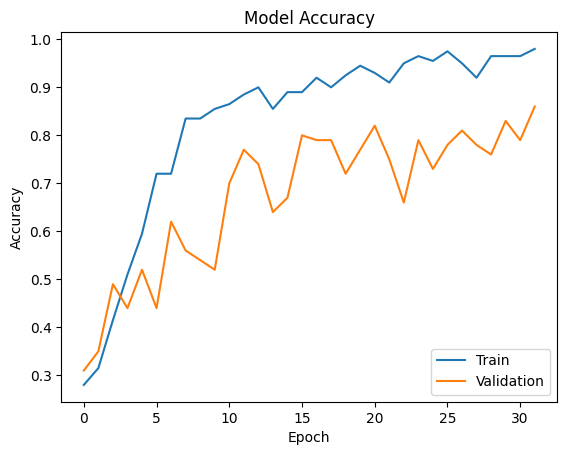

In [56]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

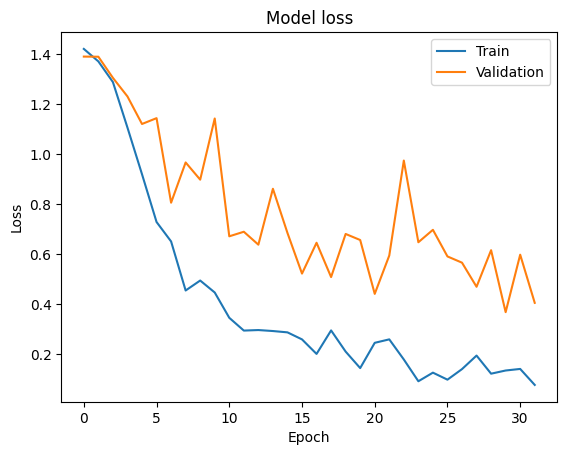

In [57]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [58]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('asl_alphabets.tflite')
tflite_model_file.write_bytes(tflite_model)

15580640

1/1 [==============================] - 0s 83ms/step
predicted class for file A_test.jpg is:
LABEL A!
1/1 [==============================] - 0s 96ms/step
predicted class for file B_test.jpg is:
LABEL B!
1/1 [==============================] - 0s 26ms/step
predicted class for file C_test.jpg is:
LABEL C!
1/1 [==============================] - 0s 33ms/step
predicted class for file D_test.jpg is:
LABEL D!


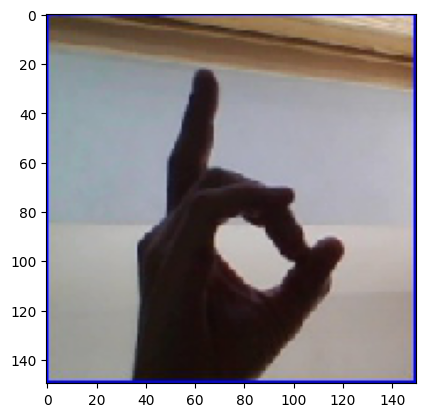

In [65]:
test_images = ["A_test.jpg","B_test.jpg","C_test.jpg","D_test.jpg"]
test_path = "/content/asl_alphabet_test/asl_alphabet_test/"
for test_image in test_images:
 
  # predicting images
  img = image.load_img(test_path+test_image, target_size=(150,150))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)  
  print("predicted class for file " + test_image +" is:")
  if classes[0][0]==1:
    print('LABEL A!')
  elif classes[0][1]==1:
    print('LABEL B!')
  elif classes[0][2]==1:
    print('LABEL C!')
  else :
    print("LABEL D!")